## Loading the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

In [2]:
# Load the data
file_path = 'Reliance_Industries_stock_data.csv'
data = pd.read_csv(file_path)

# Display the first and last few rows
data.head

<bound method NDFrame.head of             Date      Open      High       Low     Close Adj Close     Volume
0     01-01-2014    410.28    410.65    405.78    406.33    379.46  2,924,699
1     02-01-2014    405.83    409.62    397.78    400.02    373.56  3,011,816
2     03-01-2014    398.47    399.27    390.88    395.11    368.97  6,416,948
3     06-01-2014    394.12    394.65    388.59    390.85    365.00  6,657,928
4     07-01-2014    390.69    393.14    384.04    384.98    359.52  8,655,735
...          ...       ...       ...       ...       ...       ...        ...
2594  12-07-2024  3,169.00  3,210.30  3,149.00  3,193.45  3,193.45  6,462,392
2595  15-07-2024  3,208.90  3,211.70  3,171.00  3,194.45  3,194.45  2,664,844
2596  16-07-2024  3,187.00  3,200.00  3,138.25  3,152.50  3,152.50  4,693,419
2597  18-07-2024  3,152.00  3,187.80  3,115.65  3,173.35  3,173.35  6,149,187
2598  19-07-2024  3,172.00  3,179.95  3,105.60  3,110.30  3,110.30  6,570,195

[2599 rows x 7 columns]>

In [3]:
data.dtypes

Date         object
Open         object
High         object
Low          object
Close        object
Adj Close    object
Volume       object
dtype: object

In [4]:
# Convert the 'Date' column to datetime if it is not already
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Verify the conversion
print(data['Date'].dtype)  # Should be datetime64[ns]

datetime64[ns]


In [5]:
# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Verify the new index
print(data.head())
print("Index type:", type(data.index))
print("Index frequency:", data.index.freq)

              Open    High     Low   Close Adj Close     Volume
Date                                                           
2014-01-01  410.28  410.65  405.78  406.33    379.46  2,924,699
2014-01-02  405.83  409.62  397.78  400.02    373.56  3,011,816
2014-01-03  398.47  399.27  390.88  395.11    368.97  6,416,948
2014-01-06  394.12  394.65  388.59  390.85    365.00  6,657,928
2014-01-07  390.69  393.14  384.04  384.98    359.52  8,655,735
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index frequency: None


In [6]:
# Set frequency to business days
data = data.asfreq('B', method='ffill')

# Verify the frequency
print("Index frequency:", data.index.freq)

Index frequency: <BusinessDay>


## Data Cleaning

In [7]:
# Remove commas from numeric columns and convert to numeric types
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    data[col] = data[col].str.replace(',', '')  # Remove commas

# Handle invalid entries and convert to float
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN

In [8]:
# Check for Missing Values:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       2
dtype: int64

In [9]:
data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [10]:
#Handle Missing or Incorrect Data:
data.fillna(data.Volume.mean(), inplace=True)

## Summary Statistics

In [11]:
# Descriptive Statistics:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2753.000000,2753.000000,2753.000000,2753.000000,2753.000000,2.753000e+03
mean,1332.565532,1346.381195,1317.972096,1331.687337,1314.573469,9.093731e+06
std,823.559526,831.172057,815.691175,823.421649,828.746235,6.611007e+06
min,365.780000,368.840000,362.580000,365.710000,341.520000,8.528280e+05
25%,475.040000,479.110000,469.600000,474.400000,456.370000,5.359816e+06
50%,1133.820000,1147.300000,1120.380000,1133.040000,1112.730000,7.256518e+06
75%,2171.820000,2196.690000,2149.110000,2174.630000,2164.960000,1.036744e+07
max,3208.900000,3217.600000,3171.000000,3201.800000,3201.800000,7.134168e+07


## Data Visualization

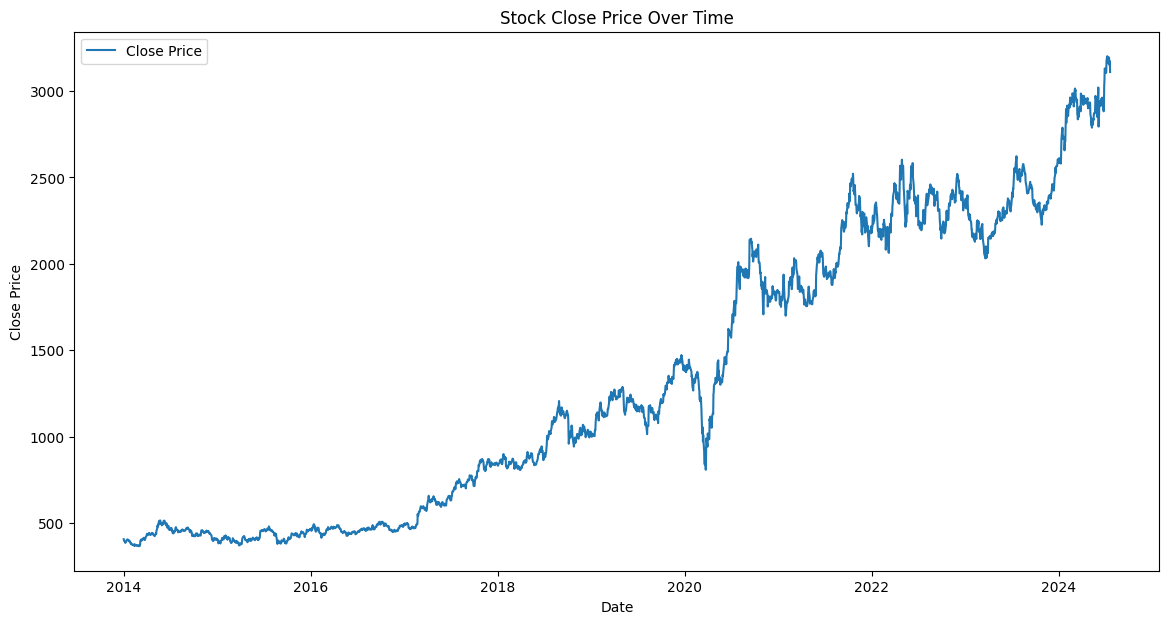

In [12]:
# Plot Time Series:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Close Price Over Time')
plt.legend()
plt.show()

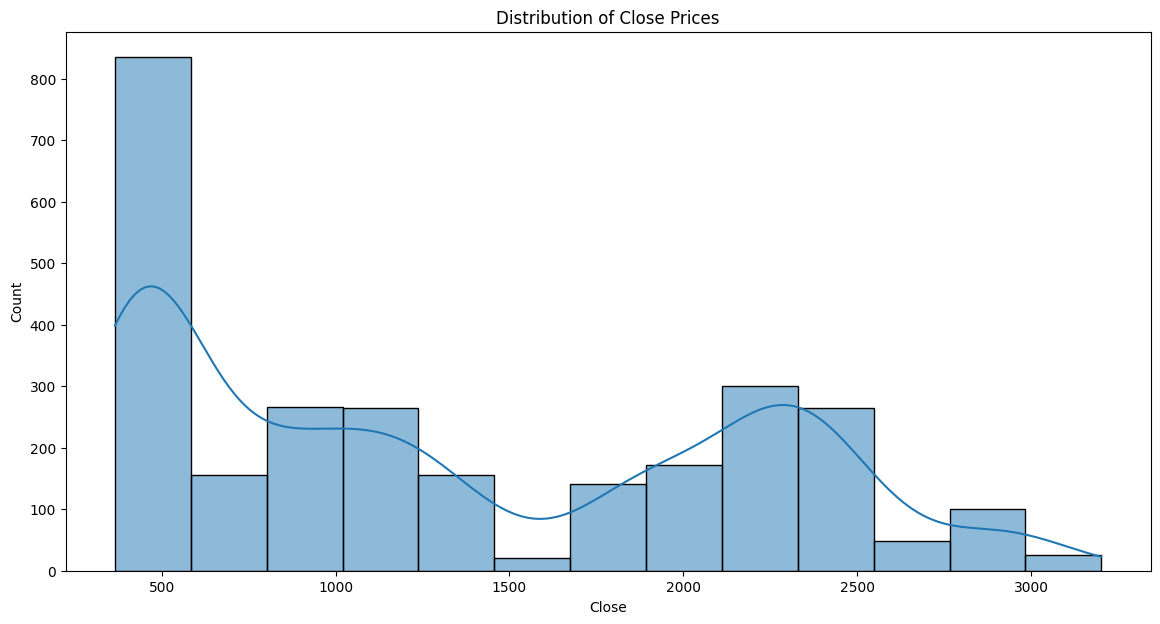

In [13]:
# Distribution of Prices:
plt.figure(figsize=(14, 7))
sns.histplot(data['Close'], kde=True)
plt.title('Distribution of Close Prices')
plt.show()

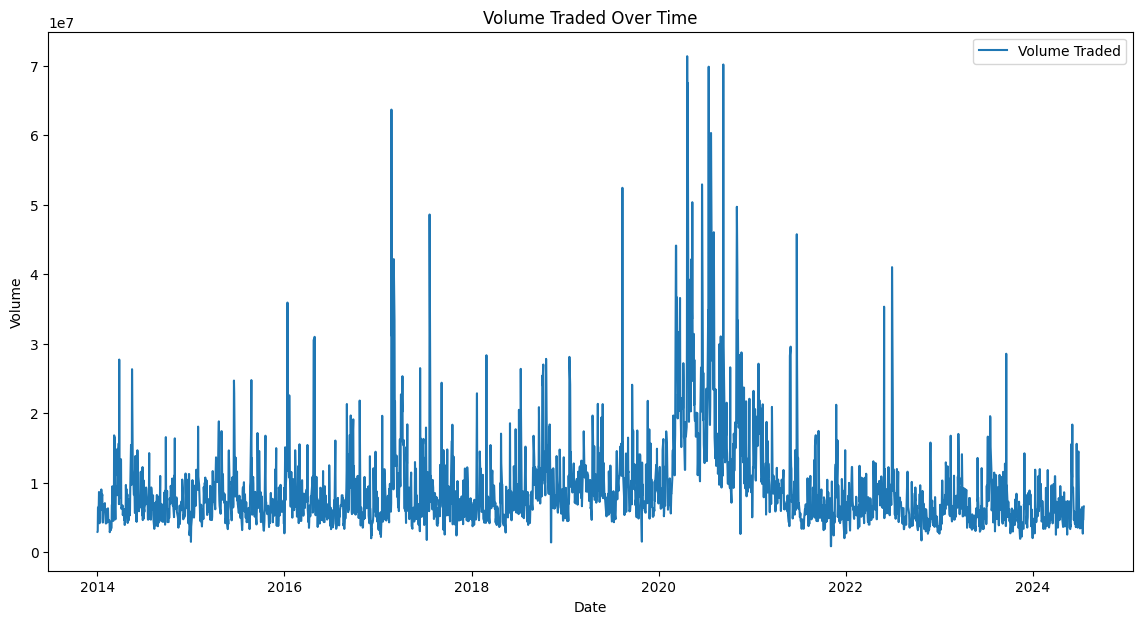

In [14]:
# Volume Traded Over Time:
plt.figure(figsize=(14, 7))
plt.plot(data['Volume'], label='Volume Traded')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Traded Over Time')
plt.legend()
plt.show()

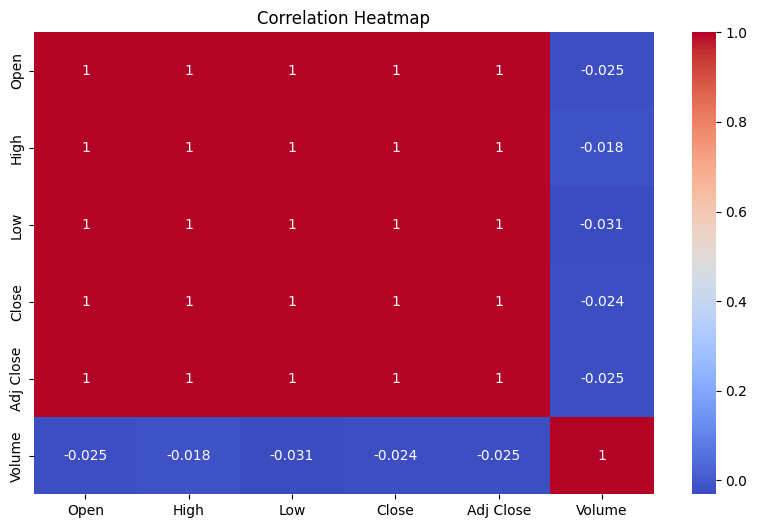

In [15]:
# Correlation Heatmap:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Time Series Analysis

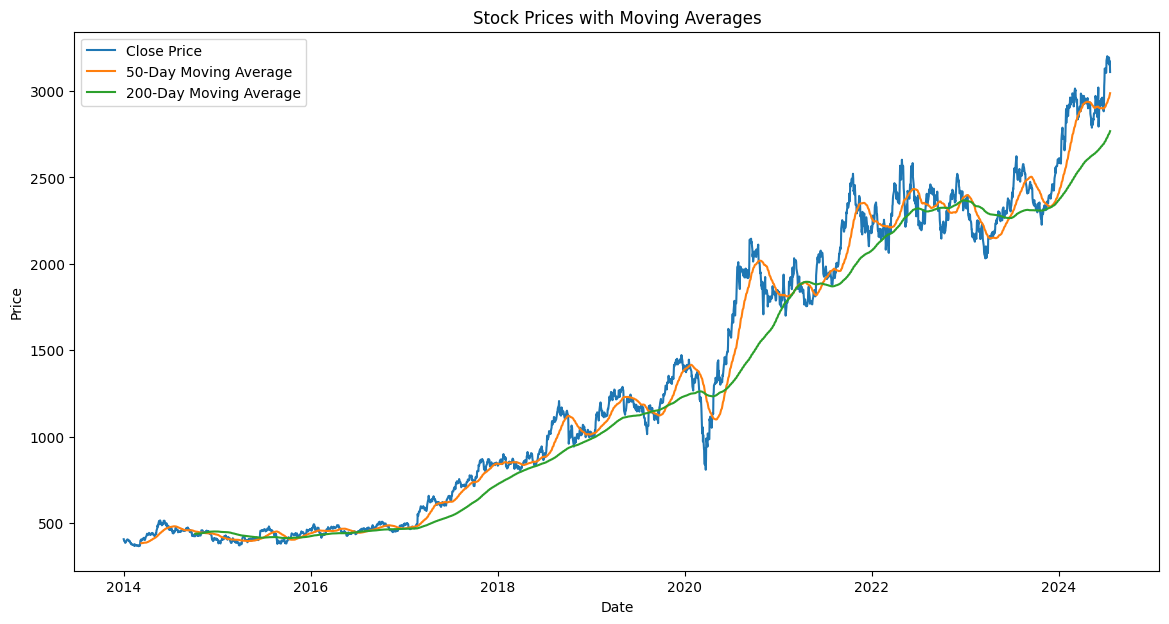

In [16]:
# Moving Averages:
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA50'], label='50-Day Moving Average')
plt.plot(data['MA200'], label='200-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices with Moving Averages')
plt.legend()
plt.show()

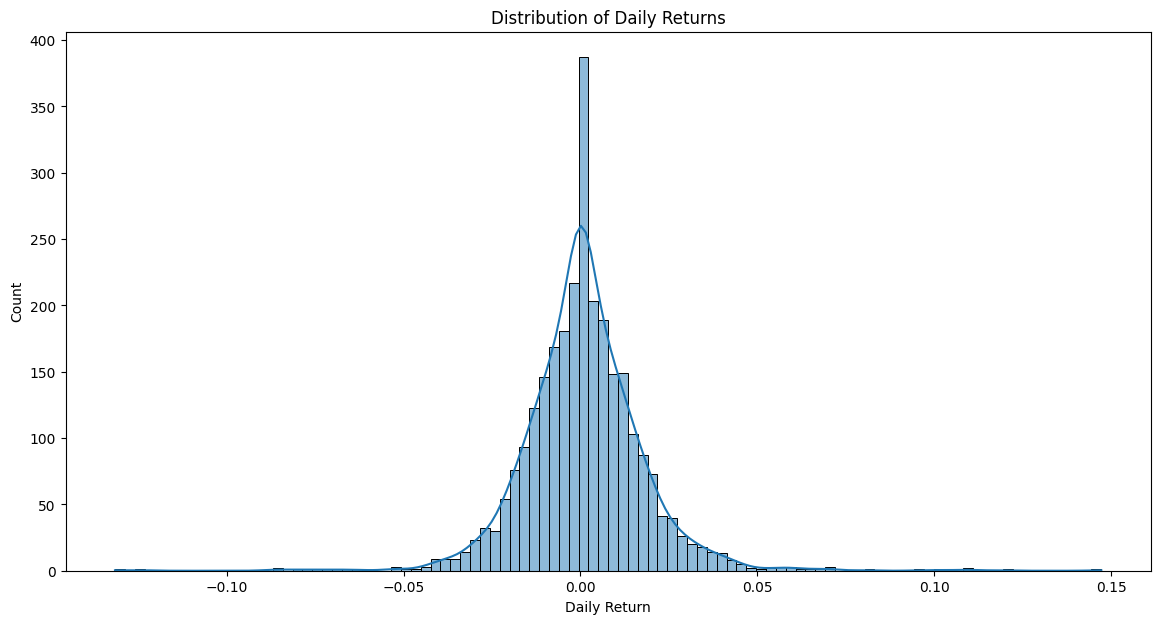

In [17]:
# Daily Returns:
data['Daily Return'] = data['Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.histplot(data['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.show()

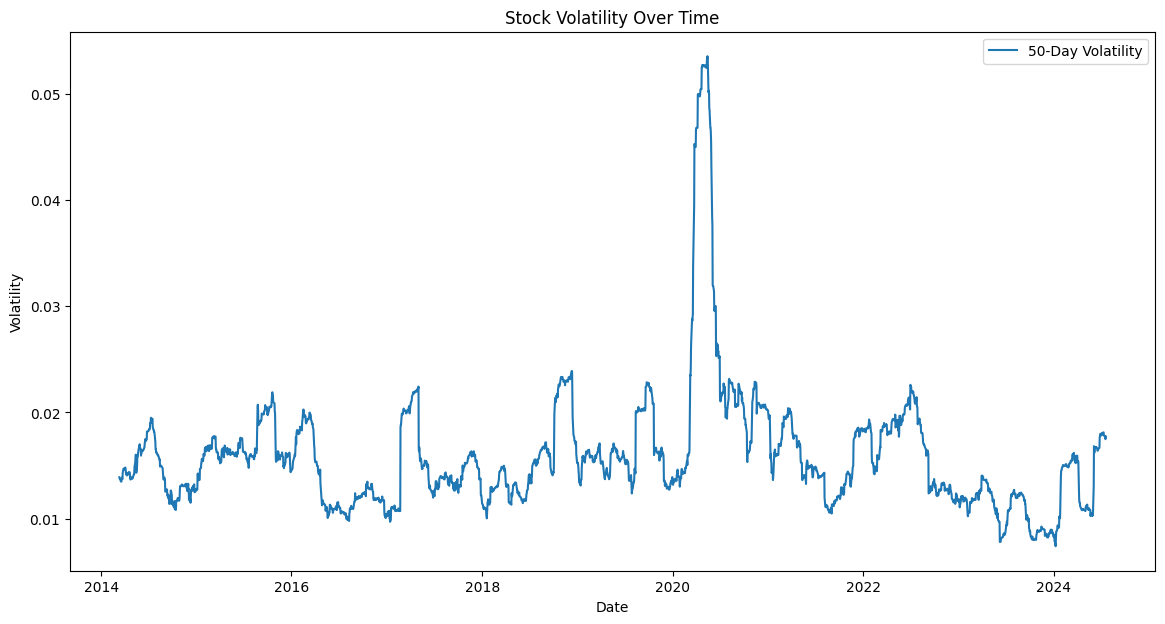

In [18]:
# Volatility:
data['Volatility'] = data['Daily Return'].rolling(window=50).std()

plt.figure(figsize=(14, 7))
plt.plot(data['Volatility'], label='50-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Stock Volatility Over Time')
plt.legend()
plt.show()

In [19]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200,Daily Return,Volatility
Date,,,,,,,,,,
2014-01-01,410.28,410.65,405.78,406.33,379.46,2924699.0,NaN,NaN,NaN,NaN
2014-01-02,405.83,409.62,397.78,400.02,373.56,3011816.0,NaN,NaN,-0.015529,NaN
2014-01-03,398.47,399.27,390.88,395.11,368.97,6416948.0,NaN,NaN,-0.012274,NaN
2014-01-06,394.12,394.65,388.59,390.85,365.00,6657928.0,NaN,NaN,-0.010782,NaN
2014-01-07,390.69,393.14,384.04,384.98,359.52,8655735.0,NaN,NaN,-0.015019,NaN


### Stationarity Check

In [20]:
# Augmented Dickey-Fuller (ADF) Test

result = adfuller(data['Close'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.29400837662988183
p-value: 0.9770679182425208


#### The high p-value (> 0.05) suggests that the null hypothesis (that the series has a unit root and is non-stationary) cannot be rejected. This indicates the series is likely non-stationary.

In [21]:
# KPSS Test

result = kpss(data['Close'].dropna(), regression='c')
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

KPSS Statistic: 8.395106161395606
p-value: 0.01


#### KPSS test checks for stationarity against a null hypothesis that the series is stationary. A very low p-value suggests rejecting the null hypothesis, indicating non-stationarity.

### ACF and PACF Analysis (Before Differencing)

<Figure size 1400x700 with 0 Axes>

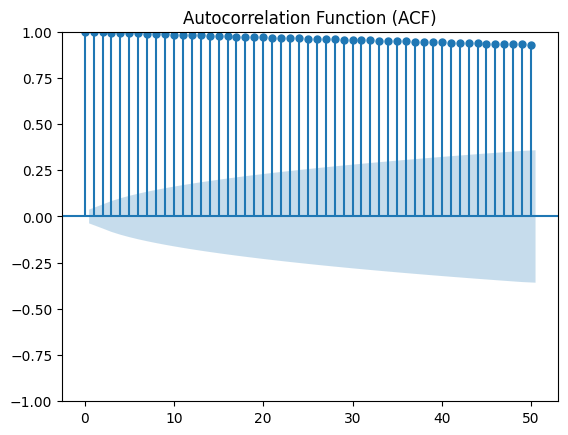

<Figure size 1400x700 with 0 Axes>

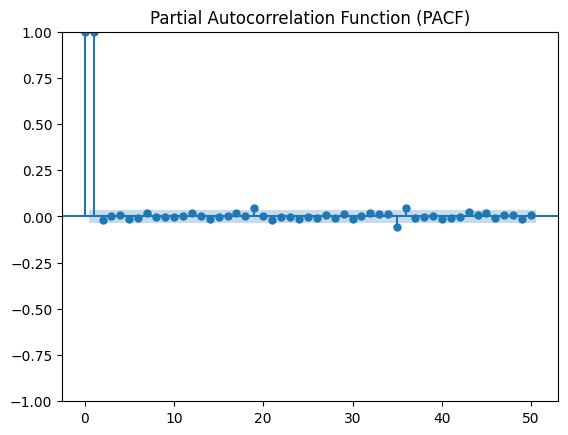

In [22]:
plt.figure(figsize=(14, 7))
plot_acf(data['Close'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(data['Close'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## Differencing

ADF Statistic (Differenced): -53.19044910756039
p-value (Differenced): 0.0
KPSS Statistic (Differenced): 0.1394403135813314
p-value (Differenced): 0.1


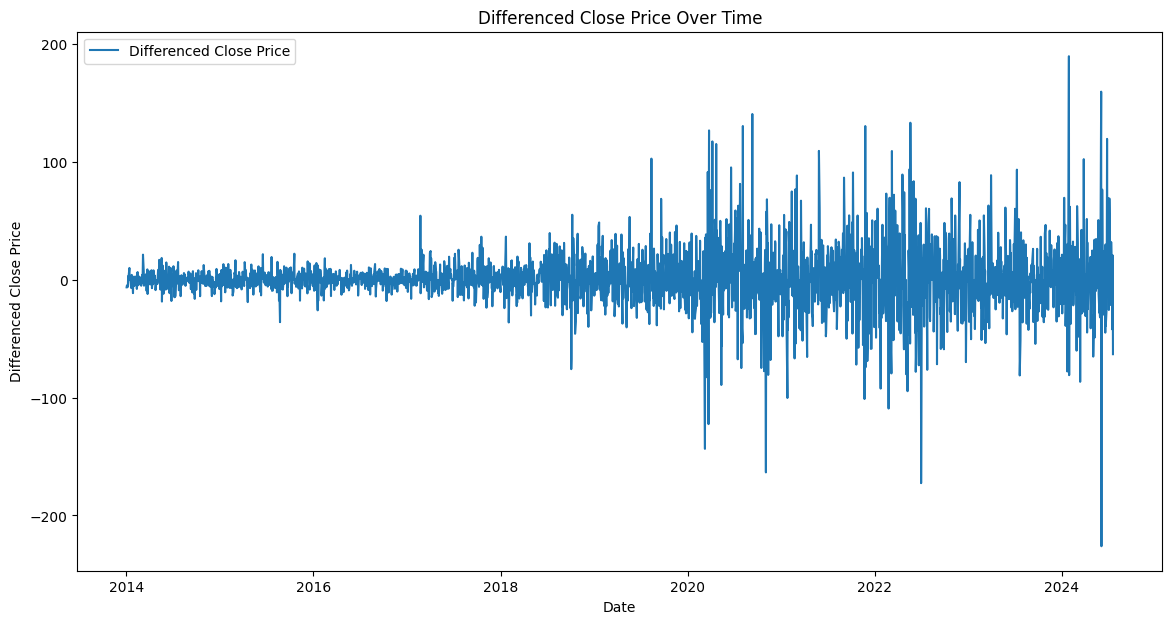

In [23]:
data['Close Diff'] = data['Close'].diff().dropna()

# Perform ADF and KPSS tests on the differenced data
adf_result_diff = adfuller(data['Close Diff'].dropna())
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

kpss_result_diff = kpss(data['Close Diff'].dropna(), regression='c')
print('KPSS Statistic (Differenced):', kpss_result_diff[0])
print('p-value (Differenced):', kpss_result_diff[1])

# Plot the differenced data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close Diff'], label='Differenced Close Price')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.legend()
plt.show()

### Detrending

ADF Statistic (Detrended): -8.922692552383259
p-value (Detrended): 1.0308576451402246e-14
KPSS Statistic (Detrended): 0.1801226568063261
p-value (Detrended): 0.1


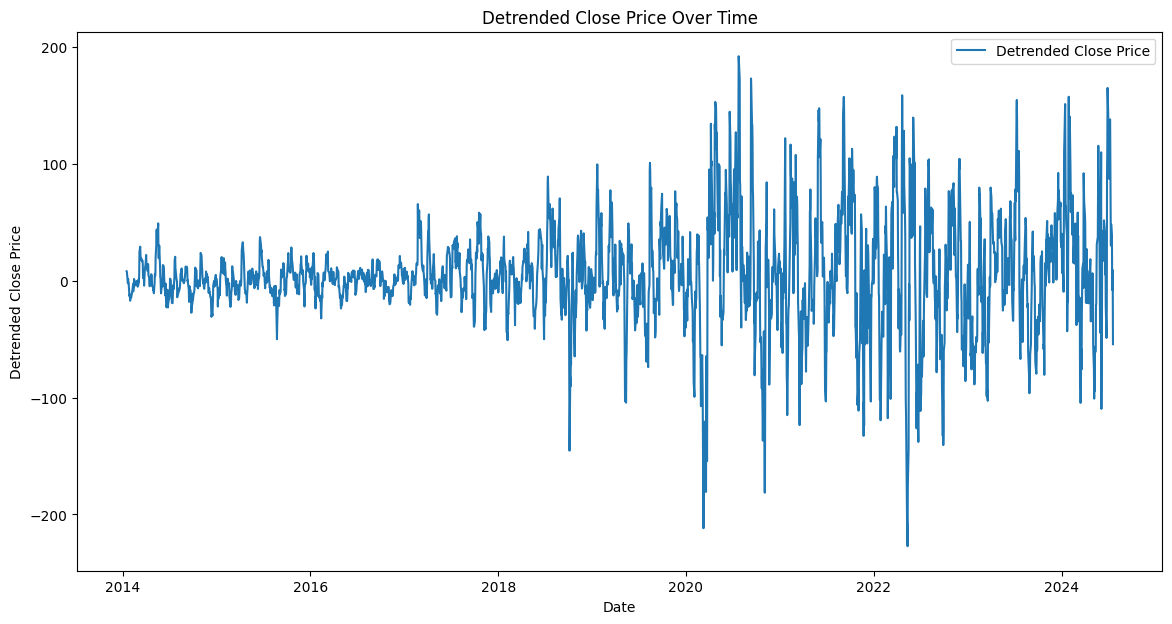

In [24]:
data['Close Detrended'] = data['Close'] - data['Close'].rolling(window=12).mean().dropna()

# Perform ADF and KPSS tests on the detrended data
adf_result_detrended = adfuller(data['Close Detrended'].dropna())
print('ADF Statistic (Detrended):', adf_result_detrended[0])
print('p-value (Detrended):', adf_result_detrended[1])

kpss_result_detrended = kpss(data['Close Detrended'].dropna(), regression='c')
print('KPSS Statistic (Detrended):', kpss_result_detrended[0])
print('p-value (Detrended):', kpss_result_detrended[1])

# Plot the detrended data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close Detrended'], label='Detrended Close Price')
plt.xlabel('Date')
plt.ylabel('Detrended Close Price')
plt.title('Detrended Close Price Over Time')
plt.legend()
plt.show()

In [25]:
pp_result = PhillipsPerron(data['Close Diff'].dropna())
print(pp_result.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -53.228
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


#### Given the test statistic (-53.228) is much smaller than the critical values at all standard significance levels (1%, 5%, 10%), and the p-value is effectively zero, you can reject the null hypothesis. This means there is strong evidence that the time series is stationary.

### ACF and PACF Analysis (After Differencing)

<Figure size 1400x700 with 0 Axes>

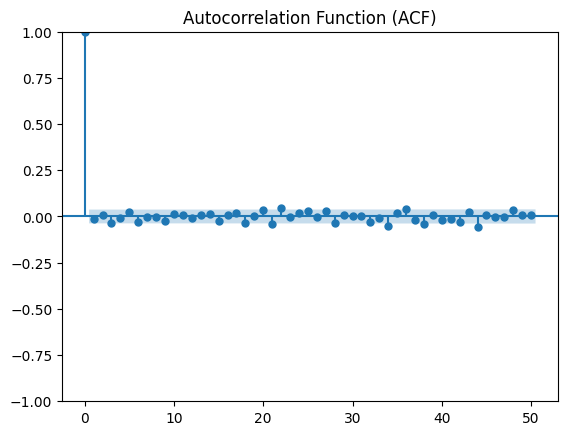

<Figure size 1400x700 with 0 Axes>

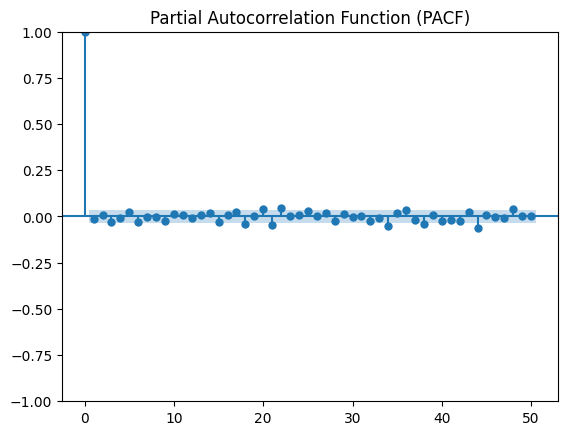

In [26]:
plt.figure(figsize=(14, 7))
plot_acf(data['Close Diff'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(data['Close Diff'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

###  Exponential Smoothing

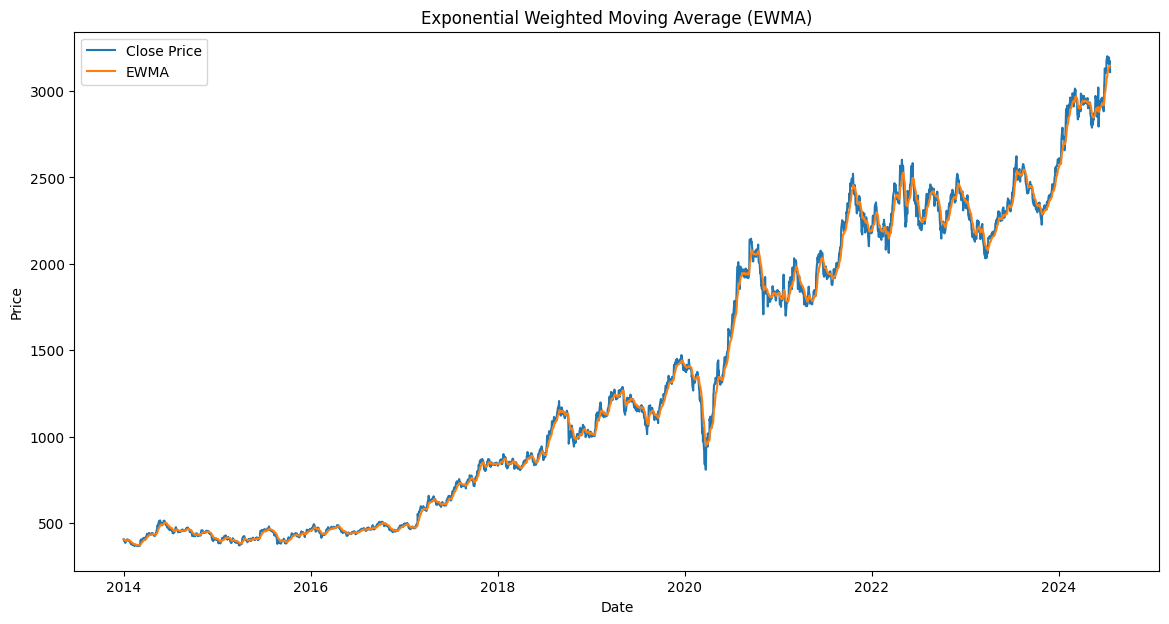

In [27]:
data['Close EWMA'] = data['Close'].ewm(span=12, adjust=False).mean()

# Plot the exponentially weighted moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['Close EWMA'], label='EWMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Exponential Weighted Moving Average (EWMA)')
plt.legend()
plt.show()

### Model Building

In [28]:
# Ensure the index is a DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

# Define the end of the test set as the last date in the dataset
end_test_date = data.index[-1]
start_test_date = end_test_date - pd.DateOffset(years=1)

# Split the data
train_data = data.loc[data.index < start_test_date]
test_data = data.loc[data.index >= start_test_date]

# Check the split
print("Training set range:", train_data.index.min(), "to", train_data.index.max())
print("Test set range:", test_data.index.min(), "to", test_data.index.max())

Training set range: 2014-01-01 00:00:00 to 2023-07-18 00:00:00
Test set range: 2023-07-19 00:00:00 to 2024-07-19 00:00:00


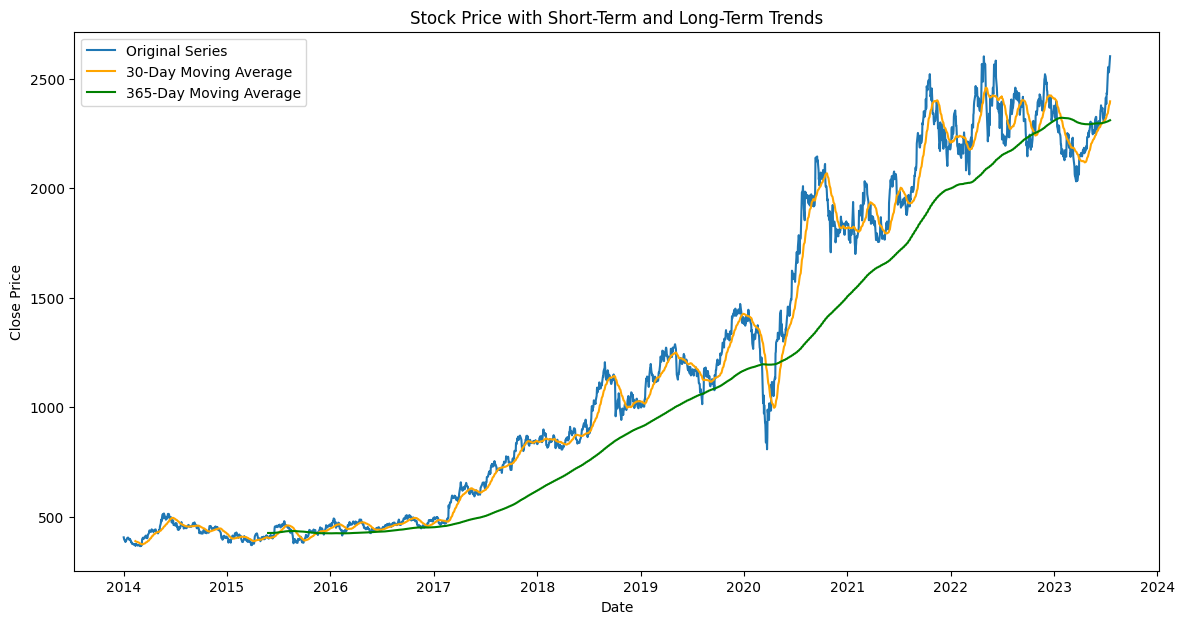

In [29]:
# Plot the original series and moving averages
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Original Series')

# Short-term trend (e.g., 30-day moving average)
short_term_ma = train_data['Close'].rolling(window=30).mean()
plt.plot(train_data.index, short_term_ma, label='30-Day Moving Average', color='orange')

# Long-term trend (e.g., 365-day moving average)
long_term_ma = train_data['Close'].rolling(window=365).mean()
plt.plot(train_data.index, long_term_ma, label='365-Day Moving Average', color='green')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Short-Term and Long-Term Trends')
plt.legend()
plt.show()

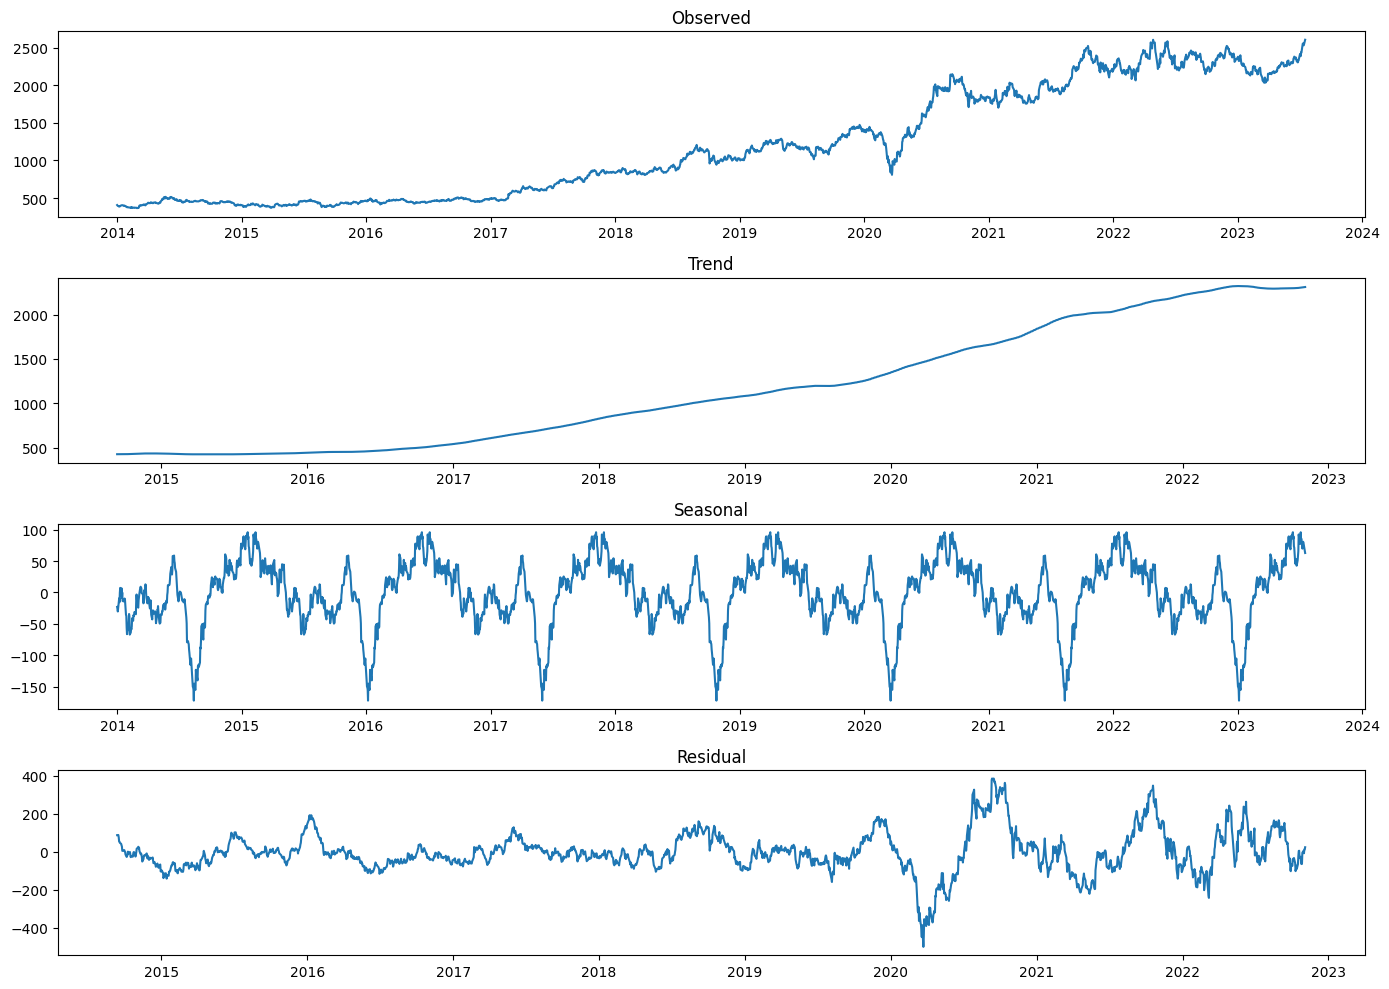

In [30]:
# Decompose the time series
decomposition = seasonal_decompose(train_data['Close'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

# Since the data shows strong seasonality we will directly go for SARIMAX

In [31]:
"""""from statsmodels.tsa.statespace.sarimax import SARIMAX

# Verify the frequency
print(data.index.freq)

# Define the seasonal period
seasonal_period = 370  # Adjust this as per your seasonal cycle

# Fit SARIMA model
model = SARIMAX(train_data['Close'], 
                order=(2, 1, 3),  # ARIMA order: Adjust based on model selection
                seasonal_order=(1, 1, 1, seasonal_period))  # SARIMA seasonal order

model_fit = model.fit()

# Print the model summary
print(model_fit.summary())"""""

'""from statsmodels.tsa.statespace.sarimax import SARIMAX\n\n# Verify the frequency\nprint(data.index.freq)\n\n# Define the seasonal period\nseasonal_period = 370  # Adjust this as per your seasonal cycle\n\n# Fit SARIMA model\nmodel = SARIMAX(train_data[\'Close\'], \n                order=(2, 1, 3),  # ARIMA order: Adjust based on model selection\n                seasonal_order=(1, 1, 1, seasonal_period))  # SARIMA seasonal order\n\nmodel_fit = model.fit()\n\n# Print the model summary\nprint(model_fit.summary())'

In [32]:
model = SARIMAX(data['Close'], 
                order=(1, 1, 1),
                seasonal_order=(1, 1, 0, 30))  # Simplified SARIMA seasonal period

model_fit = model.fit(disp=False,  method='lbfgs')
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 2753
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 30)   Log Likelihood              -13159.911
Date:                             Wed, 14 Aug 2024   AIC                          26327.821
Time:                                     13:07:10   BIC                          26351.458
Sample:                                 01-01-2014   HQIC                         26336.365
                                      - 07-19-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7177      0.169     -4.239      0.000      -1.050      -0.386
ma.L1          0.6900      

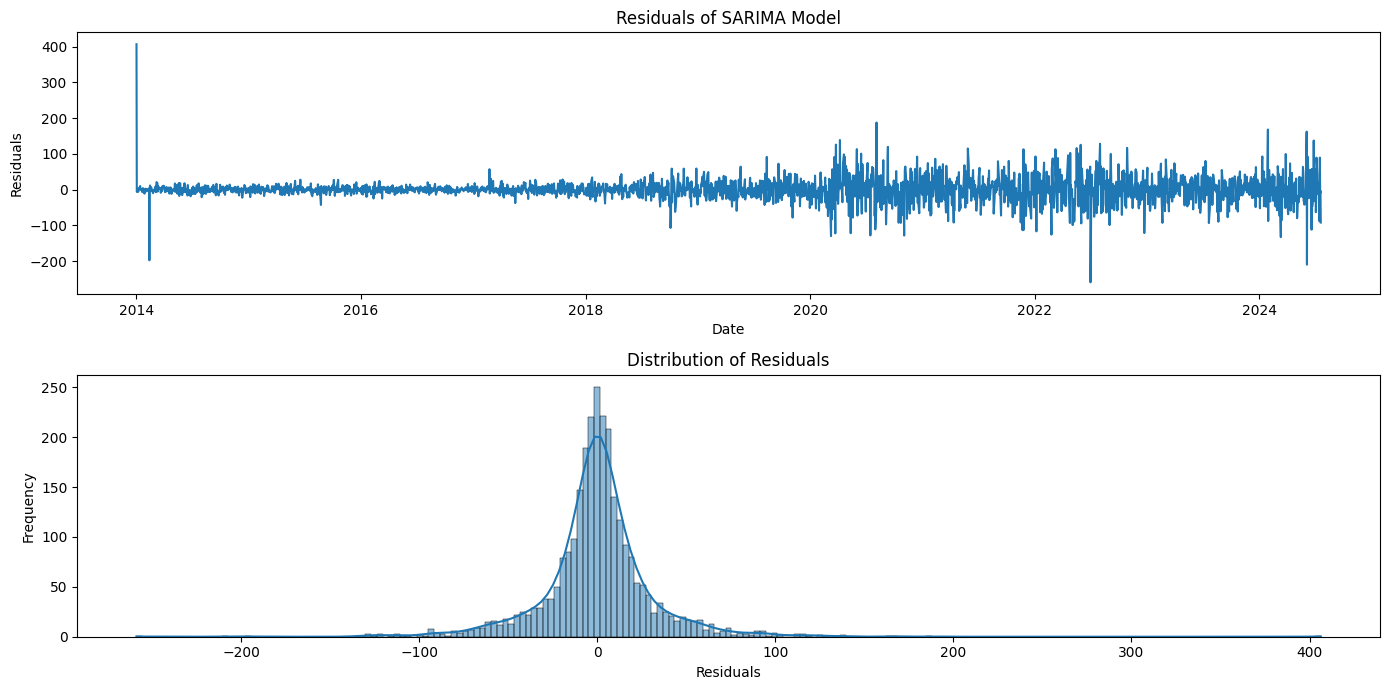

In [33]:
# Plot residuals
residuals = model_fit.resid

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

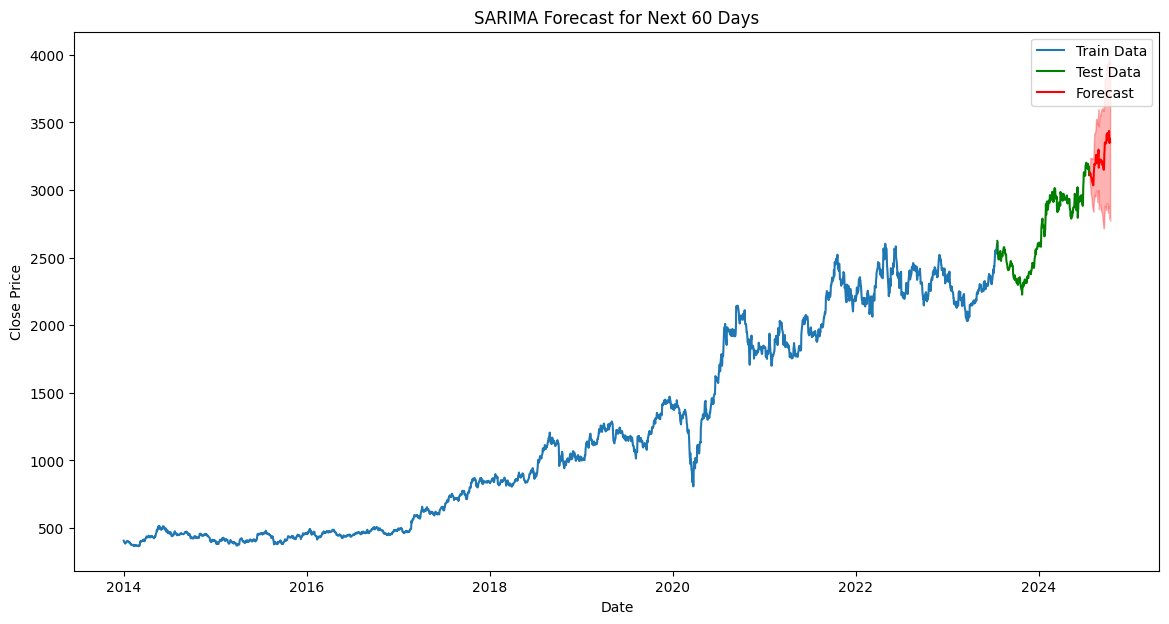

               Forecast     Lower CI     Upper CI
2024-07-22  3128.444363  3068.878219  3188.010507
2024-07-23  3112.445877  3029.366274  3195.525480
2024-07-24  3121.379628  3019.423651  3223.335605
2024-07-25  3121.279491  3003.857235  3238.701747
2024-07-26  3102.576470  2971.227857  3233.925083
2024-07-29  3087.408645  2943.653530  3231.163759
2024-07-30  3073.616400  2918.324876  3228.907924
2024-07-31  3067.539889  2901.591360  3233.488417
2024-08-01  3058.822051  2882.806833  3234.837268
2024-08-02  3052.110423  2866.610645  3237.610201
2024-08-05  3034.745457  2840.197880  3229.293034
2024-08-06  3064.641014  2861.465400  3267.816629
2024-08-07  3121.366324  2909.902523  3332.830125
2024-08-08  3146.975075  2927.544148  3366.406003
2024-08-09  3192.435808  2965.311349  3419.560266
2024-08-12  3187.109017  2952.547203  3421.670832
2024-08-13  3192.621574  2950.848319  3434.394829
2024-08-14  3204.047747  2955.273935  3452.821558
2024-08-15  3230.845856  2975.261818  3486.429894


In [34]:
# Forecast future values
forecast_steps = 60
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='B')

# Get forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the observed and forecasted values
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Close'], label='Train Data')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='green')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA Forecast for Next 60 Days')
plt.legend()
plt.show()

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_index)
forecast_df['Lower CI'] = forecast_conf_int.iloc[:, 0]
forecast_df['Upper CI'] = forecast_conf_int.iloc[:, 1]

# Print the forecasted values
print(forecast_df)